# TXST DATATHON: Library Resource Reallocation

## Research Question:
### "What does a decade of TXST Library circulation data reveal about
###  the shift from physical collections to technology and space demand,
###  and how should the library prioritize its resource reallocation?"


In [13]:
# ===============================================
# TXST DATATHON: Library Resource Reallocation
# 
# ===============================================
# Research Question:
# "What does a decade of TXST Library circulation data reveal about
#  the shift from physical collections to technology and space demand,
#  and how should the library prioritize its resource reallocation?"
# ===============================================

# 1) Imports

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from matplotlib.gridspec import GridSpec
import warnings
warnings.filterwarnings('ignore')

plt.rcParams.update({
    'figure.facecolor': 'white',
    'axes.facecolor': '#f8f9fa',
    'axes.grid': True,
    'grid.alpha': 0.3,
    'font.size': 11,
    'axes.titlesize': 14,
    'axes.titleweight': 'bold',
    'figure.titlesize': 16,
    'figure.titleweight': 'bold',
})

TXST_GOLD = '#6a5638'
TXST_MAROON = '#501214'
TXST_CREAM = '#d4c9a8'
COLORS = ['#501214', '#6a5638', '#d4c9a8', '#8b6914', '#2d5f2d', '#1a5276', '#c0392b']

print("Imports and style loaded.")



Imports and style loaded.


In [6]:
import pandas as pd

DATA_PATH = "TXST_Library_Circulation_Enrollment_Clean.xlsx"
IPEDS_PATH = "IPEDS Enrollment Data 2019-2024.csv"

# =========================
# LOAD CLEAN LIBRARY DATA
# =========================
summary_df = pd.read_excel(DATA_PATH, sheet_name="Annual Summary")
type_df    = pd.read_excel(DATA_PATH, sheet_name="Circulation by Type")
patron_df  = pd.read_excel(DATA_PATH, sheet_name="Circulation by Patron")
loc_raw    = pd.read_excel(DATA_PATH, sheet_name="Circulation by Location")

# Patron cleanup (remove note rows / blanks)
patron_df = patron_df[pd.to_numeric(patron_df["Fiscal Year"], errors="coerce").notna()].copy()
patron_df["Fiscal Year"] = patron_df["Fiscal Year"].astype(int)
patron_df = patron_df.rename(columns={"Fiscal Year": "Fiscal_Year", "Grand Total": "Grand_Total"})

# Build circ_df from Annual Summary
circ_df = (summary_df[["Fiscal Year", "Annual Circulation"]]
           .rename(columns={"Fiscal Year": "FY", "Annual Circulation": "Annual_Total"})
           .copy())
circ_df["FY"] = pd.to_numeric(circ_df["FY"], errors="coerce").astype(int)
circ_df["Annual_Total"] = pd.to_numeric(circ_df["Annual_Total"], errors="coerce")

# Keep FY19–FY24 (optional)
circ_df = circ_df[circ_df["FY"].between(2019, 2024)].copy()

# =========================
# LOAD ENROLLMENT DATA (IPEDS) - single source
# =========================
enrollment = pd.read_csv(IPEDS_PATH)  # will fail loudly if missing
enrollment["Institution (entity) name"] = (
    enrollment["Institution (entity) name"].astype(str).str.strip().str.lower()
)

txst = enrollment[enrollment["Institution (entity) name"].str.contains("texas state", na=False)].copy()
txst["Grand total"] = pd.to_numeric(txst["Grand total"], errors="coerce")
txst["Year"] = pd.to_numeric(txst["Year"], errors="coerce").astype(int)

enroll_yearly = (txst.groupby("Year")["Grand total"]
                 .max()
                 .reset_index()
                 .rename(columns={"Year": "FY", "Grand total": "Enrollment"})
                 .sort_values("FY"))

# Only keep the FYs we need (prevents extra rows from causing confusion)
enroll_yearly = enroll_yearly[enroll_yearly["FY"].between(2019, 2024)].copy()

print(enroll_yearly.to_string(index=False))

# =========================
# MERGE + PER STUDENT
# =========================
merged = circ_df.merge(enroll_yearly, on="FY", how="left")

missing = merged.loc[merged["Enrollment"].isna(), "FY"].tolist()
if missing:
    raise ValueError(f"Missing enrollment for FY(s): {missing}")

if merged["FY"].duplicated().any():
    raise ValueError("Duplicate FY rows after merge — check your inputs.")

merged["Circ_Per_Student"] = merged["Annual_Total"] / merged["Enrollment"]

print("\n=== Merged: Circulation + Enrollment ===")
print(merged[["FY", "Annual_Total", "Enrollment", "Circ_Per_Student"]].to_string(index=False))


  FY  Enrollment
2019       42780
2020       42292
2021       42111
2022       41900
2023       41676
2024       42138

=== Merged: Circulation + Enrollment ===
  FY  Annual_Total  Enrollment  Circ_Per_Student
2019        111846       42780          2.614446
2020         86065       42292          2.035018
2021         61659       42111          1.464202
2022         64315       41900          1.534964
2023         60726       41676          1.457098
2024         64090       42138          1.520955


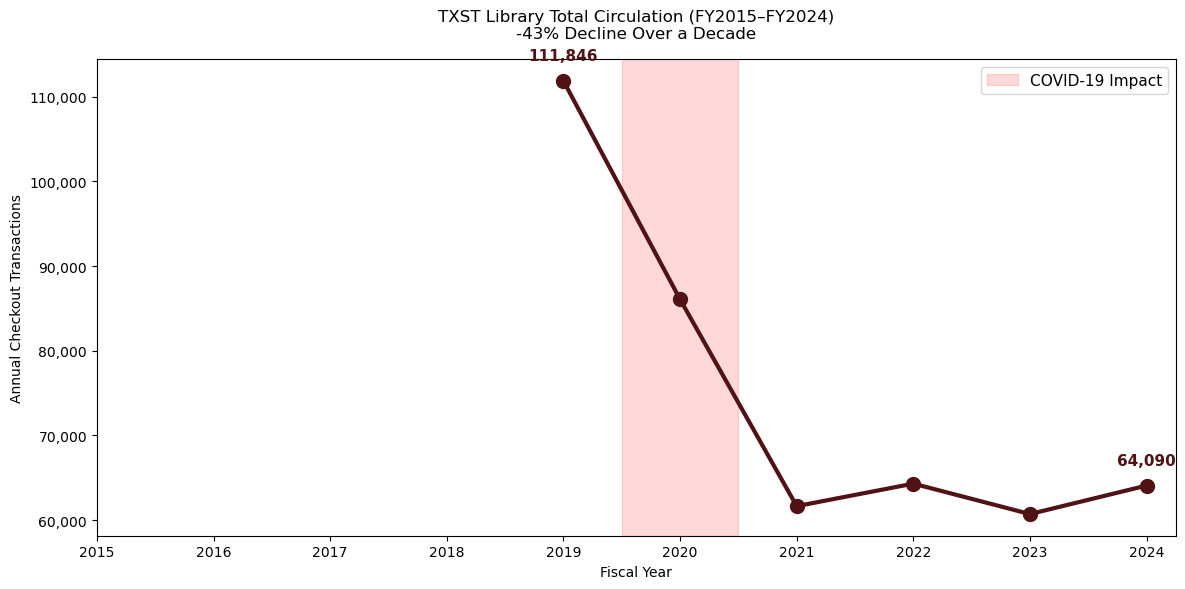

✅ Saved: 01_total_circulation_trend.png


In [7]:

# ============================================================
#  VIZ 1 — Total Circulation Decline (10 Years)
# ============================================================

fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(circ_df['FY'], circ_df['Annual_Total'], 
        color=TXST_MAROON, linewidth=3, marker='o', markersize=10, zorder=5)
ax.axvspan(2019.5, 2020.5, alpha=0.15, color='red', label='COVID-19 Impact')

ax.annotate(f"{circ_df.iloc[0]['Annual_Total']:,.0f}", 
            (circ_df.iloc[0]['FY'], circ_df.iloc[0]['Annual_Total']),
            textcoords="offset points", xytext=(0, 15), ha='center',
            fontsize=11, fontweight='bold', color=TXST_MAROON)
ax.annotate(f"{circ_df.iloc[-1]['Annual_Total']:,.0f}", 
            (circ_df.iloc[-1]['FY'], circ_df.iloc[-1]['Annual_Total']),
            textcoords="offset points", xytext=(0, 15), ha='center',
            fontsize=11, fontweight='bold', color=TXST_MAROON)

total_decline = (circ_df.iloc[-1]['Annual_Total'] - circ_df.iloc[0]['Annual_Total']) / circ_df.iloc[0]['Annual_Total'] * 100

ax.set_title(f'TXST Library Total Circulation (FY2015–FY2024)\n{total_decline:.0f}% Decline Over a Decade', pad=15)
ax.set_xlabel('Fiscal Year')
ax.set_ylabel('Annual Checkout Transactions')
ax.yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, p: f'{x:,.0f}'))
ax.set_xticks(range(2015, 2025))
ax.legend(fontsize=11)
plt.tight_layout()
plt.savefig('01_total_circulation_trend.png', dpi=200, bbox_inches='tight')
plt.show()
print("✅ Saved: 01_total_circulation_trend.png")

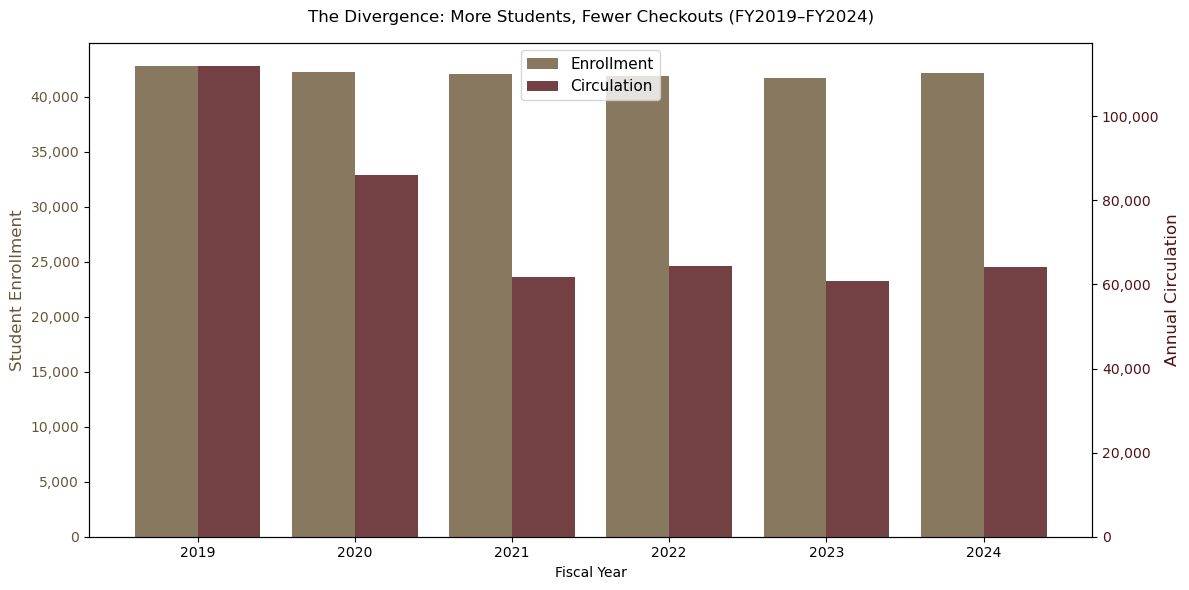

✅ Saved: 02_divergence.png


In [8]:
# ============================================================
#  VIZ 2 — Enrollment UP vs Circulation DOWN
# ============================================================

fig, ax1 = plt.subplots(figsize=(12, 6))
combo = merged.dropna(subset=['Enrollment'])

ax1.bar(combo['FY'] - 0.2, combo['Enrollment'], width=0.4, 
        color=TXST_GOLD, alpha=0.8, label='Enrollment', zorder=3)
ax1.set_ylabel('Student Enrollment', fontsize=12, color=TXST_GOLD)
ax1.yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, p: f'{x:,.0f}'))
ax1.tick_params(axis='y', labelcolor=TXST_GOLD)

ax2 = ax1.twinx()
ax2.bar(combo['FY'] + 0.2, combo['Annual_Total'], width=0.4,
        color=TXST_MAROON, alpha=0.8, label='Circulation', zorder=3)
ax2.set_ylabel('Annual Circulation', fontsize=12, color=TXST_MAROON)
ax2.yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, p: f'{x:,.0f}'))
ax2.tick_params(axis='y', labelcolor=TXST_MAROON)

ax1.set_title('The Divergence: More Students, Fewer Checkouts (FY2019–FY2024)', pad=15)
ax1.set_xlabel('Fiscal Year')
ax1.set_xticks(combo['FY'].astype(int))

lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper center', fontsize=11)
plt.tight_layout()
plt.savefig('02_divergence.png', dpi=200, bbox_inches='tight')
plt.show()
print("✅ Saved: 02_divergence.png")

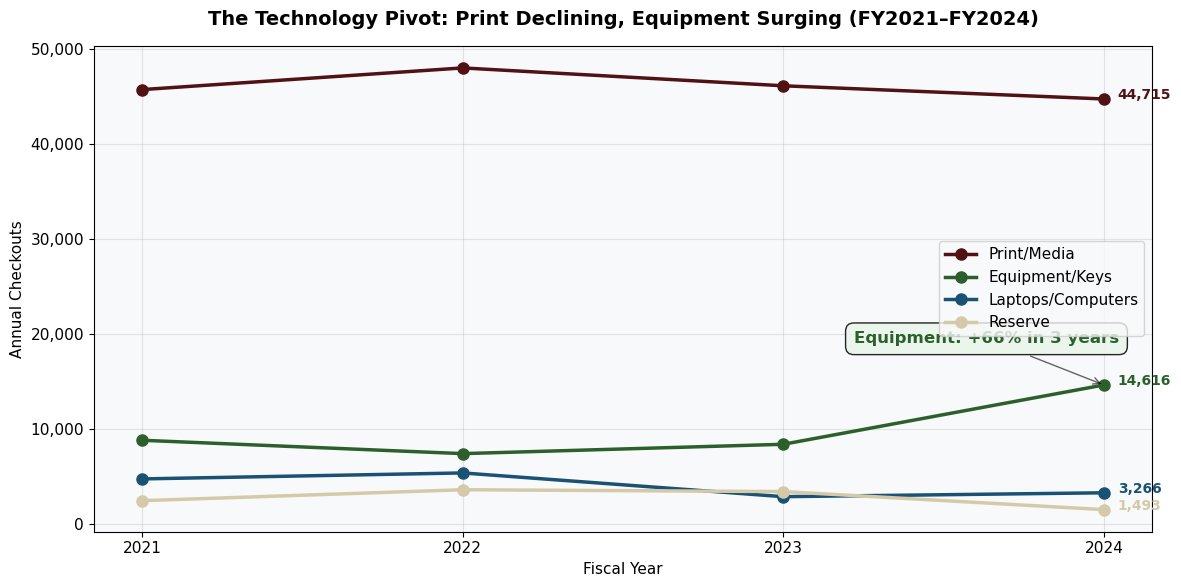

✅ Saved: 03_technology_pivot.png


In [15]:
# ============================================================
#  VIZ 3 — The Technology Pivot (FY21–FY24)
# ============================================================

tech_df = type_df.copy()

# FY column already exists per your error message, but keep robust:
if "Fiscal Year" in tech_df.columns:
    tech_df = tech_df.rename(columns={"Fiscal Year": "FY"})
tech_df["FY"] = pd.to_numeric(tech_df["FY"], errors="coerce")
tech_df = tech_df.dropna(subset=["FY"]).copy()
tech_df["FY"] = tech_df["FY"].astype(int)

tech_df = tech_df[tech_df["FY"].between(2021, 2024)].copy().sort_values("FY")

categories = {
    "Print/Media": ("Print/Media", TXST_MAROON),
    "Equipment/Keys": ("Equipment/Keys", "#2d5f2d"),
    "Laptops/Computers": ("Laptops/Computers", "#1a5276"),
    "Reserve": ("Reserve", TXST_CREAM),
}

missing_cols = [col for (col, _) in categories.values() if col not in tech_df.columns]
if missing_cols:
    raise KeyError(f"Missing these columns in type_df: {missing_cols}\nColumns: {tech_df.columns.tolist()}")

fig, ax = plt.subplots(figsize=(12, 6))

for label, (col, color) in categories.items():
    y = pd.to_numeric(tech_df[col], errors="coerce").values
    ax.plot(tech_df["FY"], y, marker="o", linewidth=2.5, markersize=8,
            label=label, color=color)

    ax.annotate(f"{y[-1]:,.0f}",
                (tech_df["FY"].iloc[-1], y[-1]),
                textcoords="offset points", xytext=(10, 0),
                fontsize=10, fontweight="bold", color=color)

# Equipment growth annotation
start = pd.to_numeric(tech_df.iloc[0]["Equipment/Keys"], errors="coerce")
end   = pd.to_numeric(tech_df.iloc[-1]["Equipment/Keys"], errors="coerce")

if pd.notna(start) and pd.notna(end) and start != 0:
    equip_growth = (end - start) / start * 100
    ax.annotate(f"Equipment: +{equip_growth:.0f}% in 3 years",
                xy=(tech_df["FY"].iloc[-1], end),
                xytext=(-180, 30), textcoords="offset points",
                fontsize=12, fontweight="bold", color="#2d5f2d",
                bbox=dict(boxstyle="round,pad=0.5", facecolor="#e8f5e9", alpha=0.85),
                arrowprops=dict(arrowstyle="->", alpha=0.6))

ax.set_title("The Technology Pivot: Print Declining, Equipment Surging (FY2021–FY2024)", pad=15)
ax.set_xlabel("Fiscal Year")
ax.set_ylabel("Annual Checkouts")
ax.yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, p: f"{x:,.0f}"))
ax.set_xticks([2021, 2022, 2023, 2024])
ax.legend(fontsize=11, loc="center right", frameon=True)

plt.tight_layout()
plt.savefig("03_technology_pivot.png", dpi=200, bbox_inches="tight")
plt.show()

print("✅ Saved: 03_technology_pivot.png")


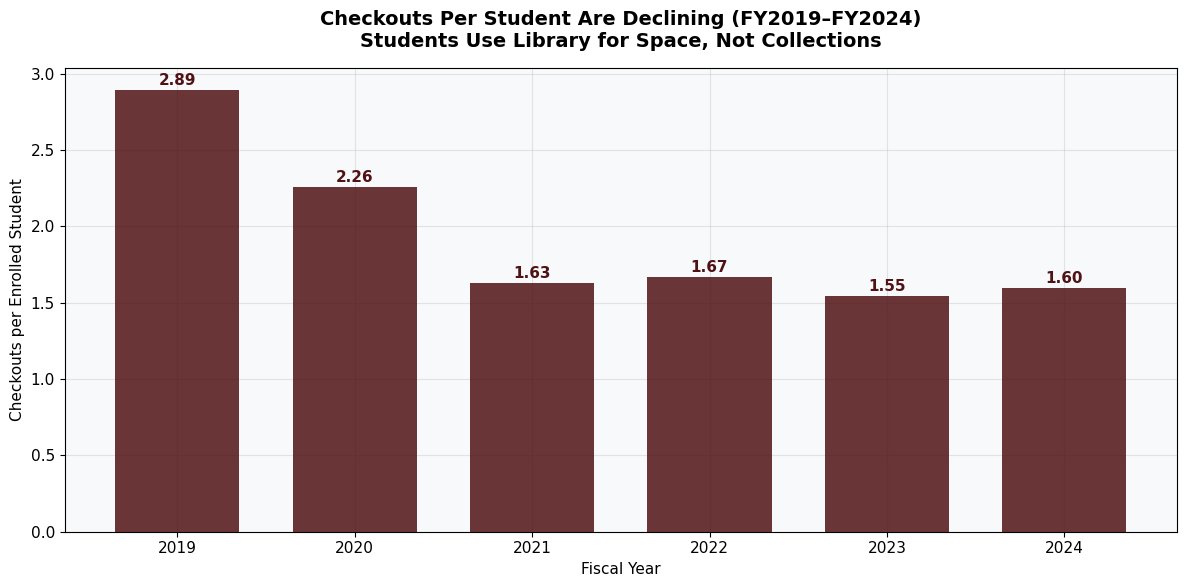

✅ Saved: 06_per_capita_circulation.png


In [21]:
# ============================================================
# VIZ 6 — Per-Capita Circulation
# ============================================================

per_cap = merged.dropna(subset=['Circ_Per_Student']).copy()

fig, ax = plt.subplots(figsize=(12, 6))
ax.bar(per_cap['FY'], per_cap['Circ_Per_Student'], color=TXST_MAROON, alpha=0.85, width=0.7, zorder=3)

for _, row in per_cap.iterrows():
    ax.text(row['FY'], row['Circ_Per_Student'] + 0.03, 
            f"{row['Circ_Per_Student']:.2f}", ha='center', fontsize=11, 
            fontweight='bold', color=TXST_MAROON)

ax.set_title('Checkouts Per Student Are Declining (FY2019–FY2024)\nStudents Use Library for Space, Not Collections', pad=15)
ax.set_xlabel('Fiscal Year')
ax.set_ylabel('Checkouts per Enrolled Student')
ax.set_xticks(per_cap['FY'].astype(int))
plt.tight_layout()
plt.savefig('06_per_capita_circulation.png', dpi=200, bbox_inches='tight')
plt.show()
print("✅ Saved: 06_per_capita_circulation.png")


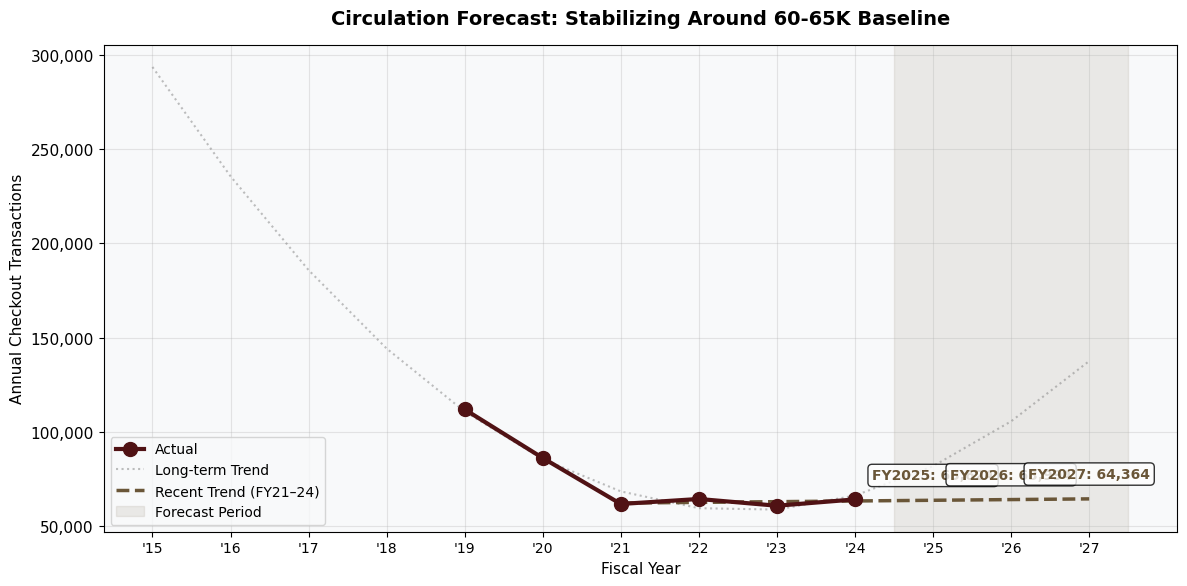


📊 Forecast Results:
  Recent trend (FY21-24): ~+370 transactions/year
  FY2025 projected: 63,624
  FY2026 projected: 63,994
  FY2027 projected: 64,364
✅ Saved: 07_circulation_forecast.png


In [19]:

# ============================================================
# PREDICTIVE — Circulation Forecast (FIXED)
# ============================================================
# Use two models: full 10-year quadratic + recent 4-year linear (stabilization)

fig, ax = plt.subplots(figsize=(12, 6))

x = circ_df['FY'].values
y = circ_df['Annual_Total'].values

# Quadratic on full data
coeffs2 = np.polyfit(x, y, 2)
poly2 = np.poly1d(coeffs2)

# Linear on RECENT data only (FY21-FY24) to show stabilization
x_recent = circ_df[circ_df['FY'] >= 2021]['FY'].values
y_recent = circ_df[circ_df['FY'] >= 2021]['Annual_Total'].values
coeffs_recent = np.polyfit(x_recent, y_recent, 1)
poly_recent = np.poly1d(coeffs_recent)

future_years = np.arange(2015, 2028)
future_recent = np.arange(2021, 2028)

ax.plot(x, y, color=TXST_MAROON, linewidth=3, marker='o', markersize=10, label='Actual', zorder=5)
ax.plot(future_years, np.maximum(poly2(future_years), 0), color='gray', linewidth=1.5, 
        linestyle=':', alpha=0.5, label='Long-term Trend')
ax.plot(future_recent, poly_recent(future_recent), color=TXST_GOLD, linewidth=2.5, 
        linestyle='--', label='Recent Trend (FY21–24)', zorder=4)

ax.axvspan(2024.5, 2027.5, alpha=0.1, color=TXST_GOLD, label='Forecast Period')

for yr in [2025, 2026, 2027]:
    val = poly_recent(yr)
    ax.annotate(f'FY{yr}: {val:,.0f}', (yr, val),
                textcoords="offset points", xytext=(0, 15), ha='center',
                fontsize=10, fontweight='bold', color=TXST_GOLD,
                bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8))

ax.set_title('Circulation Forecast: Stabilizing Around 60-65K Baseline', pad=15)
ax.set_xlabel('Fiscal Year')
ax.set_ylabel('Annual Checkout Transactions')
ax.yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, p: f'{x:,.0f}'))
ax.set_xticks(range(2015, 2028))
ax.set_xticklabels([f"'{str(y)[2:]}" for y in range(2015, 2028)], fontsize=10)
ax.legend(fontsize=10)
plt.tight_layout()
plt.savefig('07_circulation_forecast.png', dpi=200, bbox_inches='tight')
plt.show()

print(f"\n📊 Forecast Results:")
print(f"  Recent trend (FY21-24): ~{coeffs_recent[0]:+,.0f} transactions/year")
print(f"  FY2025 projected: {poly_recent(2025):,.0f}")
print(f"  FY2026 projected: {poly_recent(2026):,.0f}")
print(f"  FY2027 projected: {poly_recent(2027):,.0f}")
print("✅ Saved: 07_circulation_forecast.png")

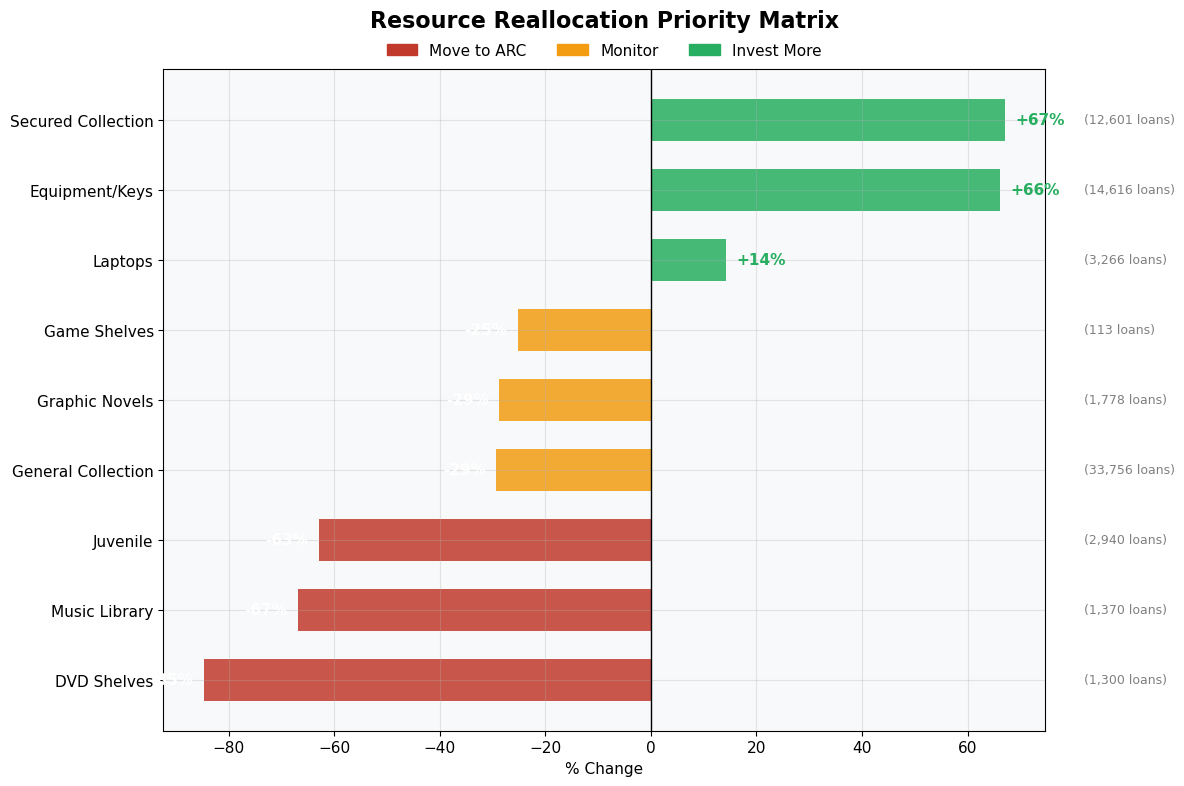

✅ Saved: 09_reallocation_matrix.png with professional legend


In [22]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np

# ============================================================
# PRESCRIPTIVE — Reallocation Priority Matrix (Fixed Tofu)
# ============================================================

fig, ax = plt.subplots(figsize=(12, 8))

# Data dictionary from your analysis
collections = {
    'General Collection': {'start': 47703, 'end': 33756, 'current': 33756, 'period': 'FY17→24'},
    'DVD Shelves':         {'start': 8514,  'end': 1300,  'current': 1300,  'period': 'FY17→24'},
    'Graphic Novels':      {'start': 2493,  'end': 1778,  'current': 1778,  'period': 'FY17→24'},
    'Juvenile':            {'start': 7919,  'end': 2940,  'current': 2940,  'period': 'FY17→24'},
    'Game Shelves':        {'start': 151,   'end': 113,   'current': 113,   'period': 'FY17→24'},
    'Music Library':       {'start': 4141,  'end': 1370,  'current': 1370,  'period': 'FY17→24'},
    'Equipment/Keys':      {'start': 8795,  'end': 14616, 'current': 14616, 'period': 'FY21→24'},
    'Laptops':             {'start': 2858,  'end': 3266,  'current': 3266,  'period': 'FY23→24'},
    'Secured Collection':  {'start': 7544,  'end': 12601, 'current': 12601, 'period': 'FY23→24'},
}

names, decline_rates, current_vols, colors_list = [], [], [], []

# Threshold logic for color coding [cite: 1031, 1034, 1037]
for name, vals in collections.items():
    rate = (vals['end'] - vals['start']) / vals['start'] * 100
    names.append(name)
    decline_rates.append(rate)
    current_vols.append(vals['current'])
    if rate < -30:
        colors_list.append('#c0392b') # Red: Move to ARC
    elif rate < 0:
        colors_list.append('#f39c12') # Orange: Monitor
    else:
        colors_list.append('#27ae60') # Green: Invest More

# Sorting by rate to create a clean visual flow [cite: 1040]
sorted_idx = np.argsort(decline_rates)
names = [names[i] for i in sorted_idx]
decline_rates = [decline_rates[i] for i in sorted_idx]
current_vols = [current_vols[i] for i in sorted_idx]
colors_list = [colors_list[i] for i in sorted_idx]

# Plotting the horizontal bars [cite: 1041]
ax.barh(range(len(names)), decline_rates, color=colors_list, alpha=0.85, height=0.6)

# Adding data labels and loan counts [cite: 1045, 1047]
for i, (rate, vol) in enumerate(zip(decline_rates, current_vols)):
    if rate < 0:
        ax.text(rate - 2, i, f'{rate:.0f}%', va='center', ha='right', 
                fontsize=11, fontweight='bold', color='white')
    else:
        ax.text(rate + 2, i, f'+{rate:.0f}%', va='center', ha='left', 
                fontsize=11, fontweight='bold', color=colors_list[i])
    ax.text(max(decline_rates) + 15, i, f'({vol:,} loans)', va='center', fontsize=9, color='gray')

# Styling the axes [cite: 1048, 1050, 1051]
ax.set_yticks(range(len(names)))
ax.set_yticklabels(names, fontsize=11)
ax.axvline(x=0, color='black', linewidth=1)
ax.set_xlabel('% Change')

# --- FIXING THE TOFU: Custom Legend Instead of Emojis ---
# Define legend handles using the same hex colors as the bars 
red_patch = mpatches.Patch(color='#c0392b', label='Move to ARC')
orange_patch = mpatches.Patch(color='#f39c12', label='Monitor')
green_patch = mpatches.Patch(color='#27ae60', label='Invest More')

# Set a bold main title
ax.set_title('Resource Reallocation Priority Matrix', fontsize=16, fontweight='bold', pad=30)

# Add the colored patches as a horizontal legend (subtitle)
ax.legend(handles=[red_patch, orange_patch, green_patch], 
          loc='upper center', 
          bbox_to_anchor=(0.5, 1.06), # Positioned above the chart area
          ncol=3, 
          frameon=False, 
          fontsize=11)

plt.tight_layout()
plt.savefig('09_reallocation_matrix.png', dpi=200, bbox_inches='tight')
plt.show()
print("✅ Saved: 09_reallocation_matrix.png with professional legend")